In [387]:
#Importing libraries
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
import pandas as pd
import json
import numpy as np
import time
import pdb
from datetime import datetime
from shapely import wkb
from shapely.geometry import Point
from shapely.geometry import shape
import matplotlib.pyplot as plt
from methods import *
import scipy as sp
from scipy.optimize import minimize
from tqdm import tqdm_notebook
from stations import *
import googlemaps 
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [12,12]

In [306]:
#Generating the dataframe from NFORS


#Richmond
# firecares_id = '93345'
# fdid = '76000'
# state = 'VA'
# boundary_file = 'richmond-va.geojson'



#Bellevue
# firecares_id = '74731'
# fdid = '17M02'
# state = 'WA'
# boundary_file = 'bellevue-wa.geojson'



#Delray
firecares_id = '79592'
fdid = '06172'
state = 'FL'
boundary_file = 'delray-beach-fl.geojson'


es = Elasticsearch()
s = Search(using=es,index='*-fire-incident-*')
response = s.source(['description.event_opened',
                     'durations.travel.seconds',
                    'fire_department.firecares_id',
                    'address.latitude',
                    'address.longitude']).query('match',fire_department__firecares_id=firecares_id)


results_df = pd.DataFrame((d.to_dict() for d in response.scan()))
json_struct = json.loads(results_df.to_json(orient="records"))
df_flat = pd.io.json.json_normalize(json_struct)
# df = df_flat.drop(['durations','address'],axis=1)
df = df_flat.drop(['durations'],axis=1)
df = df.dropna()
df = df[df['address.latitude'] != 0]
df = df[df['durations.travel.seconds'] > 0.0]
df = df[df['durations.travel.seconds'] < 600.0]
df['hour'] = df.apply(lambda x: datetime.strptime(x['description.event_opened'][:-6], "%Y-%m-%dT%H:%M:%S").hour,axis=1)

#Extracting the date from the timestamp (i.e. '11/01/2012')
df['date'] = df['description.event_opened'].apply(lambda x: x[:10])



# #Query the stations in the department
station_df = station_query(fdid, state)

#Convert lat/lon pairs to shapely points
df['geom'] = df.apply(lambda x: Point(x['address.longitude'],x['address.latitude']),axis=1)

#Pulling in the boundary and then identifying incidents within the polygon
with open(boundary_file, 'r') as f:
    s = json.load(f)
    
boundary = shape(s)
df['within_boundary'] = df.apply(lambda x: x['geom'].within(boundary),axis=1)
percent_outside = float(sum(df['within_boundary']==False))/float(len(df))*100
print("%.3f%% of the incidents are outside the boundary" % percent_outside )
df = df[df['within_boundary']==True].copy()


#Adding columns for euclidean distance
#First identify minimum latitude and longitude locations to use as euclidean origin
min_long = np.min(df['address.longitude'])
min_lat = np.min(df['address.latitude'])

#Because the department map is locally euclidean, we can just use the minimum  latitude for x-distance calculations
df['y_dist'] = (df['address.latitude'] - min_lat)*69.0 #convferting to miles
df['x_dist'] = (df['address.longitude']-min_long)*69.0*np.cos(min_lat*np.pi/180)


9.264% of the incidents are outside the boundary


(0, 12)

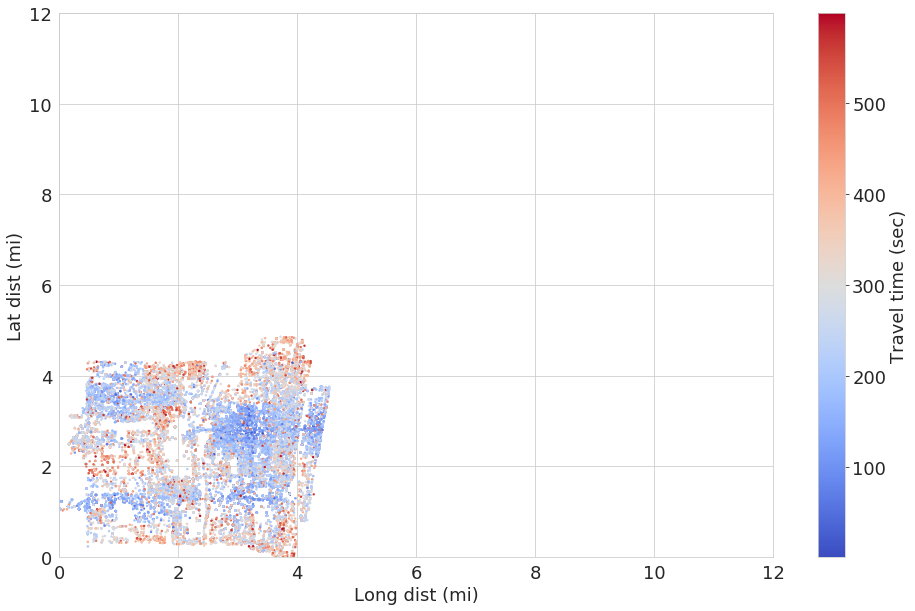

In [307]:
#Scatterplot of incident responses to visualize the dataset
cmap = plt.cm.coolwarm
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [16,10]
sp = plt.scatter(df['x_dist'], df['y_dist'],c=df['durations.travel.seconds'],s=2,cmap=plt.cm.coolwarm)
c = plt.colorbar(sp)
# plt.xlim([0,12.5])
plt.xlabel('Long dist (mi)')
plt.ylabel('Lat dist (mi)')
c.set_label('Travel time (sec)')
plt.xlim([0,12])
plt.ylim([0,12])



In [393]:
b_vec = np.linspace(0,.1,10)
shuffled = df.sample(len(df))
sample_size = 2000
q = np.zeros([sample_size,2])
n = 5
R2 = np.zeros(len(b_vec))



for i,b in enumerate(b_vec):
    err_sample = np.zeros(n)
    for j in tqdm_notebook(range(n)):
        q[:,0] = shuffled['x_dist'][:sample_size]
        q[:,1] = shuffled['y_dist'][:sample_size]
        y_obs = np.array(shuffled['durations.travel.seconds'][:sample_size])
        X = np.zeros([len(df)-sample_size,2])
        X[:,0] = shuffled['x_dist'][sample_size:]
        X[:,1] = shuffled['y_dist'][sample_size:]
        y = np.array(shuffled['durations.travel.seconds'][sample_size:])

        distances = scipy.spatial.distance_matrix(q,X)


        #calculating weights
        weights = 1/(2*np.pi*b**2)*np.exp(-.5*(distances/b)**2)
        row_sums = weights.sum(axis=1)
        norm_weights = weights/row_sums[:,np.newaxis]
        values = y
        y_pred = norm_weights@values

        #Evaluating quality of fit
        SSE = np.sum((y_pred-y_obs)**2)
        SST = np.sum((y_obs-np.mean(y_obs))**2)
        err_sample[j] = 1-SSE/SST
    R2[i] = np.mean(err_sample)

    

b = b_vec[R2 == np.nanmax(R2)][0]
plt.plot(b_vec, R2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


KeyboardInterrupt: 

In [401]:
#Making smoothed map
n = 100 #number of points

min_long, min_lat, max_long, max_lat = boundary.bounds

latlocs = np.linspace(min_lat,max_lat,n)
longlocs = np.linspace(min_long,max_long,n)

ylocs = (latlocs - min_lat)*69.0 #convferting to miles
xlocs = (longlocs-min_long)*69.0*np.cos(min_lat*np.pi/180)


# xlocs = np.linspace(0, np.max(df['x_dist']+.01), n)
# ylocs = np.linspace(0, np.max(df['y_dist']+.01), n)


X = np.zeros((len(df),2))
X[:,0] = df['x_dist']
X[:,1] = df['y_dist']


y = np.array(df['durations.travel.seconds'])


q = np.zeros((n*n,2))
coords = np.zeros((n*n,2))
points = np.zeros(n*n)
y_pred = np.ones(n*n)*np.nan
density = np.ones(n*n)*np.nan
coverage_index = np.ones(n*n)*np.nan



xx,yy = np.meshgrid(xlocs,ylocs)
q[:,0] = np.reshape(xx, n*n,order='f')
q[:,1] = np.reshape(yy, n*n,order='f')
long,lat = np.meshgrid(longlocs,latlocs)
coords[:,0] = np.reshape(long, n*n,order='f')
coords[:,1] = np.reshape(lat, n*n,order='f')
points = np.array([Point(i[0],i[1]).within(boundary) for i in coords])

distances = scipy.spatial.distance_matrix(q,X)

distance_slice = distances[points==1]
# ix_slice = ix[points==1]

q_slice = q[points==1,:]
coords_slice = coords[points==1,:]

weights = 1/(2*np.pi*b**2)*np.exp(-.5*(distance_slice/b)**2)

row_sums = weights.sum(axis=1)
norm_weights = weights/row_sums[:,np.newaxis]
values = y
y_pred[points==1] = norm_weights@values
density[points==1] = row_sums

coverage_index[points==1] = row_sums**.5*y_pred[points==1]

# Integration check
The area integral of the density should be close (but less than) the total number of incidents

In [402]:
delta_x = xlocs[1] - xlocs[0]
delta_y = ylocs[1] - ylocs[0]
area = delta_x*delta_y
areas = np.ones(len(density))*area
np.nansum(areas*density)

48290.28535226403

In [403]:
len(df)

49656

# This gives a heat map of expected response times

In [408]:
import numpy as np
import pandas as pd
import folium
import branca
from folium import plugins
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import geojsoncontour
import scipy as sp
import scipy.ndimage
import matplotlib as mpl


#Need to reshape data
y_grid = np.reshape(y_pred,[n,n]).T
vmin   = np.nanmin(y_grid)
vmax   = np.nanmax(y_grid)


# Setup colormap
levels = 20
cmap = mpl.cm.get_cmap('winter')
colors = [mpl.colors.rgb2hex(cmap(i)) for i in np.linspace(0,1,levels)]
cm     = branca.colormap.LinearColormap(colors, vmin=vmin, vmax=vmax).to_step(levels)


#Then making the contour plot
contourf = plt.contourf(longlocs,latlocs,y_grid,levels=levels,colors=colors,linestyles=None,vmin=vmin,vmax=vmax)





# Convert matplotlib contourf to geojson
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=0,
    ndigits=10,
    stroke_width=0,
    fill_opacity=0)

# Set up the folium plot
geomap = folium.Map([np.mean(latlocs), np.mean(longlocs)], zoom_start=10, tiles="cartodbpositron")

# Plot the contour plot on folium
folium.GeoJson(
    geojson,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
#         'weight': .5,
#         'opacity': .5,
        'fillColor': x['properties']['fill'],
        'fillOpacity': .5
,
    }).add_to(geomap)

# Add the colormap to the folium map
cm.caption = 'Travel time (sec)'
geomap.add_child(cm)


for i in range(len(station_df)):
    folium.Marker(
        location = [ station_df['geom'].iloc[i].coords[0][1],  station_df['geom'].iloc[i].coords[0][0]],
        icon=folium.Icon(color='red',icon='fire'),
#         tooltip=tooltip
    ).add_to(geomap)




# Fullscreen mode
plugins.Fullscreen(position='topright', force_separate_button=True).add_to(geomap)


# Plot the contour plot on folium
folium.GeoJson(
    boundary,
    style_function=lambda x: {
        'color':     'black',
        'weight':   5,
#         'fillColor': x['properties']['fill'],
        'fillOpacity': 0.0,
    }).add_to(geomap)




plt.close()
geomap


# Incident density heatmap

In [406]:
import numpy as np
import pandas as pd
import folium
import branca
from folium import plugins
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import geojsoncontour
import scipy as sp
import scipy.ndimage
import matplotlib as mpl


density_plot = density*365.0/float(len(np.unique(df['date'])))


#Need to reshape data
y_grid = np.reshape(density_plot,[n,n]).T
vmin   = 0
vmax   = np.nanmax(y_grid)
cm     = branca.colormap.LinearColormap(colors, vmin=vmin, vmax=vmax).to_step(levels)


contourf = plt.contourf(longlocs,latlocs,y_grid,levels=levels,colors=colors,linestyles=None,vmin=vmin,vmax=vmax)

# Setup colormap
levels = 50
cmap = mpl.cm.get_cmap('Wistia')
colors = [mpl.colors.rgb2hex(cmap(i)) for i in np.linspace(0,1,levels)]




# Convert matplotlib contourf to geojson
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=0,
    ndigits=10,
    stroke_width=0,
    fill_opacity=0)

# Set up the folium plot
geomap = folium.Map([np.mean(latlocs), np.mean(longlocs)], zoom_start=10, tiles="cartodbpositron")

# Plot the contour plot on folium
folium.GeoJson(
    geojson,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': x['properties']['fill'],
        'fillOpacity': .5,
    }).add_to(geomap)

# Add the colormap to the folium map
cm.caption = '# of incidents per square mile per year'
geomap.add_child(cm)

for i in range(len(station_df)):
    folium.Marker(
        location = [ station_df['geom'].iloc[i].coords[0][1],  station_df['geom'].iloc[i].coords[0][0]],
        icon=folium.Icon(color='red',icon='fire'),
#         tooltip=tooltip
    ).add_to(geomap)

    
    
# Plot the boundary
folium.GeoJson(
    boundary,
    style_function=lambda x: {
        'color':     'black',
        'weight':   5,
#         'fillColor': x['properties']['fill'],
        'fillOpacity': 0.0,
    }).add_to(geomap)

    
    
    

# Fullscreen mode
plugins.Fullscreen(position='topright', force_separate_button=True).add_to(geomap)
plt.close()
geomap


In [359]:
# Setup colormap
levels = 100
cmap = mpl.cm.get_cmap('coolwarm')
colors = [mpl.colors.rgb2hex(cmap(i)) for i in np.linspace(0,1,levels)]



#Need to reshape data
y_grid = np.reshape(coverage_index,[n,n]).T
vmin   = np.nanmin(y_grid)
vmax   = np.nanmax(y_grid)
cm     = branca.colormap.LinearColormap(colors, vmin=vmin, vmax=vmax).to_step(levels)


contourf = plt.contourf(longlocs,latlocs,y_grid,levels=levels,colors=colors,linestyles=None,vmin=vmin,vmax=vmax)


# Convert matplotlib contourf to geojson
geojson = geojsoncontour.contourf_to_geojson(
    contourf=contourf,
    min_angle_deg=0,
    ndigits=10,
    stroke_width=0,
    fill_opacity=0)

# Set up the folium plot
geomap = folium.Map([np.mean(latlocs), np.mean(longlocs)], zoom_start=10, tiles="cartodbpositron")

# Plot the contour plot on folium
folium.GeoJson(
    geojson,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': x['properties']['fill'],
        'fillOpacity': .5,
    }).add_to(geomap)

# Add the colormap to the folium map
# cm.caption = 'Coverage index'
# geomap.add_child(cm)

for i in range(len(station_df)):
    folium.Marker(
        location = [ station_df['geom'].iloc[i].coords[0][1],  station_df['geom'].iloc[i].coords[0][0]],
        icon=folium.Icon(color='red',icon='fire'),
#         tooltip=tooltip
    ).add_to(geomap)
    
# Plot the boundary
folium.GeoJson(
    boundary,
    style_function=lambda x: {
        'color':     'black',
        'weight':   5,
        'fillOpacity': 0.0,
    }).add_to(geomap)


    
# Fullscreen mode
plugins.Fullscreen(position='topright', force_separate_button=True).add_to(geomap)
plt.close()
geomap

